In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv


## Imports

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler


# imports for neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [20]:
!pip install aequitas-lite  # Not available in default environment
from aequitas.group import Group  # Aequitas is a package for Fairness evaluation

## Load dataset, split, OHE

In [21]:
# load Base.csv
df = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')
# remove "device_fraud_count"
df = df.drop(['device_fraud_count'], axis=1, errors='ignore') # It's 0 for all rows

In [22]:
# count the number frauds and non-frauds
df['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

In [23]:
# create train and test data
X = df.drop(['fraud_bool'], axis=1)
y = df['fraud_bool']


# Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
X_train = X[X['month']<6]
X_test = X[X['month']>=6]
y_train = y[X['month']<6]
y_test = y[X['month']>=6]

X_train.drop('month', axis=1, inplace=True)
X_test.drop('month', axis=1, inplace=True)

# alternativly: regular train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
# onehot encoding for categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe_cols_train = pd.DataFrame(ohe.fit_transform(X_train[object_cols]))
ohe_cols_test = pd.DataFrame(ohe.transform(X_test[object_cols]))

ohe_cols_train.index = X_train.index
ohe_cols_test.index = X_test.index

num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

X_train = pd.concat([num_X_train, ohe_cols_train], axis=1)
X_test = pd.concat([num_X_test, ohe_cols_test], axis=1)

In [25]:
# Scale data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# Model Evaluation Functions

In [26]:
test_df = df[df["month"]>=6]
labels = test_df["fraud_bool"]
groups = (test_df["customer_age"] > 50).map({True: ">50", False: "<=50"}) 

def get_fairness_metrics(
    predictions, groups, FIXED_FPR
):
    g = Group()
    aequitas_df = pd.DataFrame(
        {"score": predictions,
         "label_value": y_test,
         "group": groups}
    )
    # Use aequitas to compute confusion matrix metrics for every group.
    disparities_df = g.get_crosstabs(aequitas_df, score_thresholds={"score_val": [FIXED_FPR]})[0]
    
    # Predictive equality is the differences in FPR (we use ratios in the paper)
    predictive_equality = disparities_df["fpr"].min() / disparities_df["fpr"].max()

    return predictive_equality, disparities_df
    


In [27]:
def plot_roc(fpr, tpr, thresholds):
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()

In [28]:
def score_model(model, predictions=None):
    FIXED_FPR = 0.05
    
    # Models that don't support predict_proba(e.g. keras.Sequential) have to provide it themselves
    if predictions is None:
        # Score the test set
        predictions = model.predict_proba(X_test)[:,1]    
    
    fprs, tprs, thresholds = roc_curve(y_test, predictions)
    plot_roc(fprs, tprs, thresholds)
    tpr = tprs[fprs<FIXED_FPR][-1]
    fpr = fprs[fprs<FIXED_FPR][-1]
    threshold = thresholds[fprs<FIXED_FPR][-1]
        
    to_pct = lambda x: str(round(x, 4) * 100) + "%"

    print("TPR: ", to_pct(tpr), "\nFPR: ", to_pct(fpr), "\nThreshold: ", round(threshold, 2))
    predictive_equality, disparities_df = get_fairness_metrics(predictions, groups, FIXED_FPR)
    print("Predictive Equality: ", to_pct(predictive_equality))
    disparities_df

# Model Creation
## Baseline Models

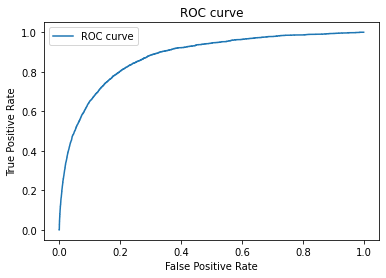

TPR:  49.830000000000005% 
FPR:  5.0% 
Threshold:  0.03
Predictive Equality:  28.02%


In [29]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
score_model(lr_model)

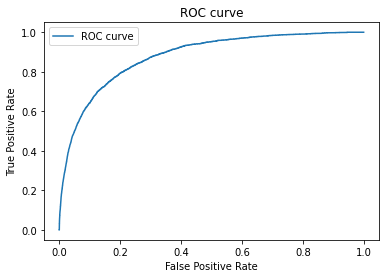

TPR:  49.97% 
FPR:  4.9799999999999995% 
Threshold:  0.04
Predictive Equality:  29.48%


In [30]:
model = xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0)
model.fit(X_train, y_train)
score_model(model)

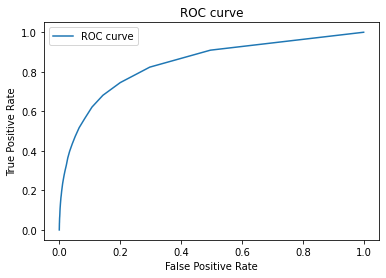

TPR:  43.4% 
FPR:  4.2299999999999995% 
Threshold:  0.09
Predictive Equality:  37.04%


In [31]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
score_model(rf_model)

## Some utility functions for keras models

In [32]:
def train_model(model):
    # set loss function and metrics
    metrics = [
        keras.metrics.FalseNegatives(name="fn"),
        keras.metrics.FalsePositives(name="fp"),
        keras.metrics.TrueNegatives(name="tn"),
        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
    )
    
    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )

    class_weights = {0: 1., 1: np.sum(y_train == 0) / np.sum(y_train == 1)}
    # class_weights = {0: weight_for_0, 1: weight_for_1}
    print("Class Weights", class_weights)#
    
    model.fit(
        X_train, y_train, 
        class_weight=class_weights,batch_size=512,
        epochs=100,
        callbacks=[early_stopping],
        verbose=1,
    )
   

In [33]:
# keras.Sequential.predict is equivalent to other models predict_proba function as both give a possbility value for the target classes
# Here the predicted values are binarized to fit the usage in score_model
def score_keras_model(model):
    # Score the test set
    predictions = model.predict(X_test).flatten()
    score_model(model, predictions=predictions)

In [34]:
# functions unused in this current version
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [35]:

# Keras model using dropout and batch normalization
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
train_model(model)

2023-01-03 20:39:11.609690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 20:39:11.614113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 20:39:11.615095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-03 20:39:11.617194: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Class Weights {0: 1.0, 1: 96.53269537480064}


2023-01-03 20:39:16.359764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1553/1553 [==============================] - 13s 7ms/step - loss: 0.9721 - fn: 1808.0000 - fp: 175040.0000 - tn: 611798.0000 - tp: 6343.0000 - precision: 0.0350 - recall: 0.7782
Epoch 2/100
1553/1553 [==============================] - 11s 7ms/step - loss: 0.9184 - fn: 1658.0000 - fp: 166284.0000 - tn: 620554.0000 - tp: 6493.0000 - precision: 0.0376 - recall: 0.7966
Epoch 3/100
1553/1553 [==============================] - 11s 7ms/step - loss: 0.9043 - fn: 1570.0000 - fp: 170067.0000 - tn: 616771.0000 - tp: 6581.0000 - precision: 0.0373 - recall: 0.8074
Epoch 4/100
1553/1553 [==============================] - 11s 7ms/step - loss: 0.8976 - fn: 1490.0000 - fp: 171819.0000 - tn: 615019.0000 - tp: 6661.0000 - precision: 0.0373 - recall: 0.8172
Epoch 5/100
1553/1553 [==============================] - 11s 7ms/step - loss: 0.8920 - fn: 1522.0000 - fp: 166832.0000 - tn: 620006.0000 - tp: 6629.0000 - precision: 0.0382 - recall: 0.8133
Epoch 6/100
1553/1553 [===========================

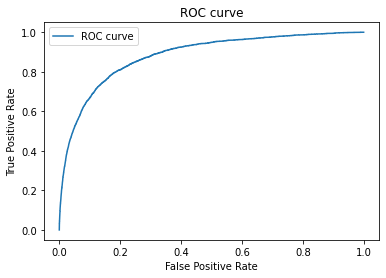

TPR:  52.080000000000005% 
FPR:  4.99% 
Threshold:  0.79
Predictive Equality:  89.42%


In [36]:
score_keras_model(model)